## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [67]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer

import re
import string
import spacy

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [68]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
!ls  "/content/drive/My Drive/Automatic_Ticket_Classification_Project/Project_data/"

complaints-2021-05-14_08_16.json


In [70]:
# Opening JSON file
# f =  "/content/drive/My Drive/Automatic_Ticket_Classification_Project/Project_data/complaints-2021-05-14_08_16.json"# Write the path to your data file and load it

# # returns JSON object as
# # a dictionary
# data = json.load(f)
# df=pd.json_normalize(data)

file_path = "/content/drive/My Drive/Automatic_Ticket_Classification_Project/Project_data/complaints-2021-05-14_08_16.json"
with open(file_path, "r") as f:
    data = json.load(f)
df=pd.json_normalize(data)


## Data preparation

In [71]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [72]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [73]:
#Assign new column names


In [74]:
print(df[["_source.complaint_what_happened", "_source.product"]])


                         _source.complaint_what_happened  \
0                                                          
1      Good morning my name is XXXX XXXX and I apprec...   
2      I upgraded my XXXX XXXX card in XX/XX/2018 and...   
3                                                          
4                                                          
...                                                  ...   
78308                                                      
78309  On Wednesday, XX/XX/XXXX I called Chas, my XXX...   
78310  I am not familiar with XXXX pay and did not un...   
78311  I have had flawless credit for 30 yrs. I've ha...   
78312  Roughly 10+ years ago I closed out my accounts...   

                   _source.product  
0                  Debt collection  
1                  Debt collection  
2      Credit card or prepaid card  
3                         Mortgage  
4      Credit card or prepaid card  
...                            ...  
78308  Checking or s

It appears that the customer complaints are in this column: "_source.complaint_what_happened" and the product that it relates to is in the column  "_source.product". The other columns do not look relevant to this exercise. Consequently we will only assign the name for these two columns.



In [75]:
df.rename(columns={'_source.complaint_what_happened':'complaint_what_happened', '_source.product':'tag'}, inplace=True)

In [76]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'] = df['complaint_what_happened'].replace("", np.nan)

In [77]:
#Remove all rows where complaints column is nan
df.dropna(subset=['complaint_what_happened'], inplace=True)

In [78]:
# Checking the shape of the dataframe again
df.shape

(21072, 22)

Conclusion: The number of rows have reduced from 78313 to 21072 due to the blank customer complains being removed

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [79]:
# Write your function here to clean the text and remove all the unnecessary elements.


def preprocess_text(text):
    """
    Cleans the input text by:
    - Converting it to lowercase
    - Removing text within square brackets
    - Eliminating punctuation
    - Filtering out words that contain numbers
    """

    # Convert text to lowercase
    cleaned_text = text.lower()

    # Remove content inside square brackets
    cleaned_text = re.sub(r'\[.*?\]', '', cleaned_text)

    # Remove punctuation marks
    cleaned_text = re.sub(f"[{re.escape(string.punctuation)}]", '', cleaned_text)

    # Remove words containing numbers
    cleaned_text = re.sub(r'\b\w*\d\w*\b', '', cleaned_text)

    return cleaned_text


In [80]:
# Load the English NLP model
nlp = spacy.load("en_core_web_sm")

def extract_nouns(text):
    """
    This function performs:
    - Lemmatization of text
    - Extracts POS tags and keeps only nouns (NN)
    """

    # Process text with spaCy
    doc = nlp(text)

    # Extract lemmas only for nouns (NN)
    noun_lemmas = [token.lemma_ for token in doc if token.pos_ == "NOUN"]

    # Return the processed text as a string
    return " ".join(noun_lemmas)


In [81]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints

# Create a new DataFrame for cleaned complaints
df_clean = pd.DataFrame()

# Apply the text preprocessing function
df_clean["complaint_what_happened"] = df["complaint_what_happened"].dropna().apply(preprocess_text)

# Apply the lemmatization + noun extraction function
df_clean["lemmatized_complaint"] = df_clean["complaint_what_happened"].apply(extract_nouns)

# Display the first few rows of the new DataFrame
df_clean.head()



,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in and was told ...,xxxx card agent anniversary date agent informa...
10,chase card was reported on however fraudulent...,card application identity consent service cred...
11,on while trying to book a xxxx xxxx ticket ...,xxxx ticket offer ticket reward card informati...
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...


In [82]:
df_clean

,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in and was told ...,xxxx card agent anniversary date agent informa...
10,chase card was reported on however fraudulent...,card application identity consent service cred...
11,on while trying to book a xxxx xxxx ticket ...,xxxx ticket offer ticket reward card informati...
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...
...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxx credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,xxxx pay risk consumer chase bank app chase ye...
78311,i have had flawless credit for yrs ive had ch...,credit yrs chase credit card chase freedom pro...


In [83]:
#Write your function to extract the POS

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

def extract_singular_nouns(text):
    """
    Extracts only singular nouns (NN) from the given text using spaCy.
    """

    # Process the text with spaCy
    doc = nlp(text)

    # Keep only words tagged as singular nouns (NN)
    noun_only_text = " ".join([token.text for token in doc if token.tag_ == "NN"])

    return noun_only_text

# Apply the function to filter only singular nouns and store in a new column
df_clean["complaint_POS_removed"] = df_clean["lemmatized_complaint"].apply(extract_singular_nouns)

# Display the first few rows of the updated DataFrame
df_clean.head()



,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in and was told ...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,card application identity consent service cred...,card application identity consent service cred...
11,on while trying to book a xxxx xxxx ticket ...,xxxx ticket offer ticket reward card informati...,xxxx ticket ticket reward card information min...
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...,account fund bank account money son money bank...


In [ ]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




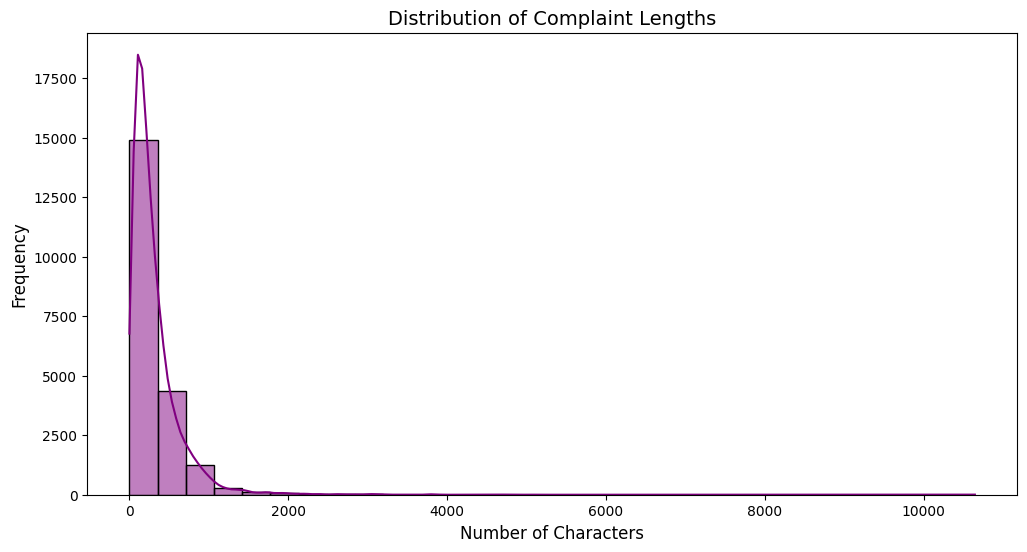

In [84]:
# Write your code here to visualise the data according to the 'Complaint' character length

# Calculate character length of each complaint
df_clean["complaint_length"] = df_clean["complaint_POS_removed"].str.len()

# Plot distribution
plt.figure(figsize=(12,6))
sns.histplot(df_clean["complaint_length"], bins=30, kde=True, color="purple")
plt.title("Distribution of Complaint Lengths", fontsize=14)
plt.xlabel("Number of Characters", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()


#### Find the top 40 words by frequency among all the articles after processing the text.

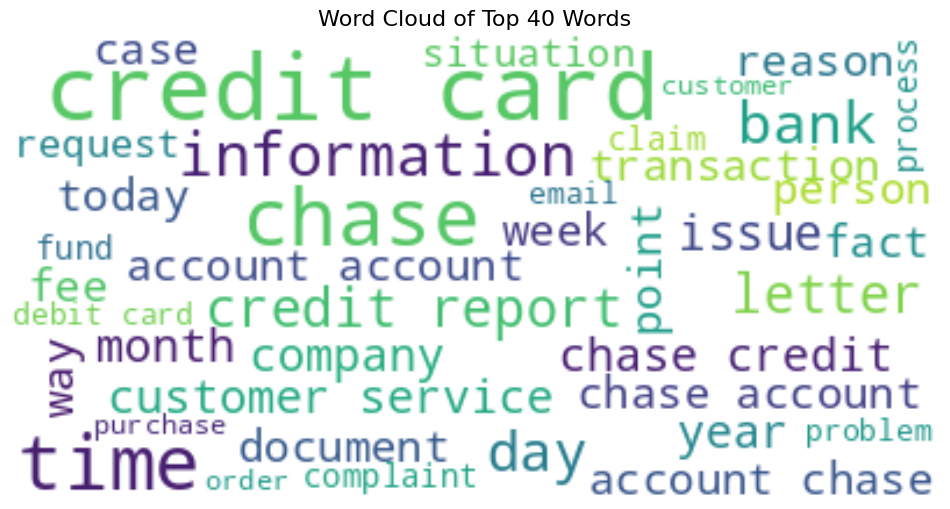

In [85]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

from wordcloud import WordCloud, STOPWORDS

# Define a set of words to exclude
stopwords = set(STOPWORDS)

# Create a WordCloud with a limit of 40 words
wordcloud = WordCloud(
    background_color="white",
    stopwords=stopwords,
    max_words=40,
    max_font_size=40,
    random_state=42
).generate(" ".join(df_clean["complaint_POS_removed"]))

# Plot and display the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axis for cleaner look
plt.title("Word Cloud of Top 40 Words", fontsize=16)
plt.show()


In [86]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [87]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,complaint_length,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,127,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in and was told ...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information ...,100,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,card application identity consent service cred...,card application identity consent service cred...,67,card application identity consent service cred...
11,on while trying to book a xxxx xxxx ticket ...,xxxx ticket offer ticket reward card informati...,xxxx ticket ticket reward card information min...,334,xxxx ticket ticket reward card information min...
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...,account fund bank account money son money bank...,129,account fund bank account money son money bank...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [88]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).


def get_top_n_grams(text_data, n=1, top_k=10):
    """
    Extracts the top-k most frequent n-grams (unigrams, bigrams, or trigrams) from the given text.

    Parameters:
    -----------
    text_data : list or Pandas Series
        The corpus of texts from which to extract n-grams.
    n : int
        Size of the n-gram (1 = unigrams, 2 = bigrams, 3 = trigrams, etc.).
    top_k : int
        Number of top n-grams to retrieve.

    Returns:
    --------
    list of tuples (ngram, frequency)
        Each tuple contains the n-gram and its overall frequency in the corpus.
    """

    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    transformed_data = vectorizer.fit_transform(text_data)

    # Sum the counts of each n-gram across all documents
    word_counts = transformed_data.sum(axis=0)

    # Map each n-gram to its frequency
    freq_map = [
        (ngram, word_counts[0, idx])
        for ngram, idx in vectorizer.vocabulary_.items()
    ]

    # Sort by frequency in descending order
    sorted_freq_map = sorted(freq_map, key=lambda x: x[1], reverse=True)

    # Return the top_k n-grams
    return sorted_freq_map[:top_k]

# Example usage: extracting unigrams, bigrams, and trigrams
top_30_unigrams = get_top_n_grams(df_clean["complaint_POS_removed"], n=1, top_k=30)
top_30_bigrams = get_top_n_grams(df_clean["complaint_POS_removed"], n=2, top_k=30)
top_30_trigrams = get_top_n_grams(df_clean["complaint_POS_removed"], n=3, top_k=30)

# Converting results to DataFrames for easy viewing
df_unigrams = pd.DataFrame(top_30_unigrams, columns=["Unigram", "Frequency"])
df_bigrams = pd.DataFrame(top_30_bigrams, columns=["Bigram", "Frequency"])
df_trigrams = pd.DataFrame(top_30_trigrams, columns=["Trigram", "Frequency"])

print("Top 30 Unigrams:\n", df_unigrams)
print("\nTop 30 Bigrams:\n", df_bigrams)
print("\nTop 30 Trigrams:\n", df_trigrams)



Top 30 Unigrams:
         Unigram  Frequency
0         chase      43190
1       account      38867
2        credit      32045
3          card      29924
4       payment      21083
5          time      15835
6          bank      13190
7           day      12784
8         money      11330
9          xxxx      10845
10       charge      10605
11         loan      10288
12  information       8929
13          fee       8864
14       number       8578
15       letter       8501
16        month       8412
17         year       8221
18     customer       8065
19     mortgage       7563
20      balance       7546
21        phone       7426
22      service       7241
23        check       6873
24      company       6769
25  transaction       6537
26         fund       6453
27       report       6207
28        fraud       6058
29        email       5542

Top 30 Bigrams:
               Bigram  Frequency
0        credit card      12813
1      credit report       3738
2       chase credit       2991

In [89]:
#Print the top 10 words in the unigram frequency

# Display the top 10 unigrams
print("Top 10 Unigrams:")
print(df_unigrams.head(10))


Top 10 Unigrams:
   Unigram  Frequency
0    chase      43190
1  account      38867
2   credit      32045
3     card      29924
4  payment      21083
5     time      15835
6     bank      13190
7      day      12784
8    money      11330
9     xxxx      10845


In [90]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

def get_top_bigrams(text_data, top_k=30):
    """
    Returns the most common bigrams (two-word sequences) in the given text corpus.

    Parameters:
    -----------
    text_data : list or pd.Series
        Collection of documents (strings) to analyze.
    top_k : int
        The number of top bigrams to retrieve.

    Returns:
    --------
    list of tuples [(bigram, frequency), ...]
        Sorted in descending order by frequency.
    """

    # Initialize CountVectorizer for bigrams
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words="english")
    transformed_data = vectorizer.fit_transform(text_data)

    # Sum the counts of each bigram
    counts = transformed_data.sum(axis=0)

    # Create a list of (bigram, frequency) pairs
    bigram_freqs = [
        (bigram, counts[0, idx])
        for bigram, idx in vectorizer.vocabulary_.items()
    ]

    # Sort in descending order by frequency
    sorted_bigram_freqs = sorted(bigram_freqs, key=lambda x: x[1], reverse=True)

    return sorted_bigram_freqs[:top_k]

# Use the function to get the top 30 bigrams in the processed text
bigrams_top_30 = get_top_bigrams(df_clean["complaint_POS_removed"].values.astype("U"), top_k=30)

# Convert the result into a DataFrame
df_bigrams = pd.DataFrame(bigrams_top_30, columns=["Bigram", "Frequency"])

# Display the top 30 bigrams
print(df_bigrams)


              Bigram  Frequency
0        credit card      12813
1      credit report       3738
2       chase credit       2991
3   customer service       2973
4    account account       2682
5      chase account       2642
6      account chase       2421
7         debit card       1869
8         card chase       1758
9       card account       1733
10   payment payment       1719
11      credit score       1696
12        chase card       1680
13    account credit       1595
14     money account       1431
15      bank account       1359
16         card card       1357
17      phone number       1267
18       card credit       1233
19    account number       1177
20      card company       1163
21       number xxxx       1140
22     payment chase       1138
23      fund account       1082
24   payment account       1077
25    charge account       1070
26  mortgage payment       1051
27     chase payment       1040
28      business day       1034
29       chase chase       1026


In [91]:
#Print the top 10 words in the bigram frequency
print("\nTop 10 Bigram Words:")
print(df_bigrams["Bigram"].head(10))


Top 10 Bigram Words:
0         credit card
1       credit report
2        chase credit
3    customer service
4     account account
5       chase account
6       account chase
7          debit card
8          card chase
9        card account
Name: Bigram, dtype: object


In [92]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).


def get_top_trigrams(corpus, top_k=30):
    """
    Extracts the top_k most frequent trigrams from a given text corpus.

    Parameters:
      corpus (list or pd.Series): The text data to analyze.
      top_k (int): The number of top trigrams to return.

    Returns:
      list of tuples: Each tuple contains a trigram and its frequency.
    """
    # Initialize CountVectorizer for trigrams (3-word sequences)
    vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english')
    X = vectorizer.fit_transform(corpus)

    # Sum up the counts for each trigram
    trigram_counts = X.sum(axis=0)

    # Map trigrams to their frequencies
    trigram_freqs = [
        (trigram, trigram_counts[0, idx])
        for trigram, idx in vectorizer.vocabulary_.items()
    ]

    # Sort the list by frequency in descending order
    trigram_freqs_sorted = sorted(trigram_freqs, key=lambda x: x[1], reverse=True)

    return trigram_freqs_sorted[:top_k]

# Apply the function to the processed text column in df_clean
top_30_trigrams = get_top_trigrams(df_clean['complaint_POS_removed'].values.astype('U'), top_k=30)

# Convert the results to a DataFrame for easy viewing
df_trigrams = pd.DataFrame(top_30_trigrams, columns=['trigram', 'count'])

# Print the top 30 trigrams
print(df_trigrams)


                    trigram  count
0         chase credit card   1959
1       credit card account   1021
2       credit card company   1003
3         credit card chase    819
4        credit card credit    617
5          xxxx credit card    554
6     inquiry credit report    523
7          card credit card    497
8       account credit card    464
9      credit report credit    406
10  credit reporting agency    385
11      credit card payment    351
12    account credit report    335
13         credit card card    313
14      credit card balance    288
15       charge credit card    277
16         bank credit card    269
17         credit card xxxx    268
18         credit card bank    258
19    account chase account    256
20      payment credit card    254
21       credit card charge    252
22      credit card service    240
23      credit report chase    235
24      freedom credit card    235
25  account account account    233
26       chase card service    231
27       chase auto 

In [93]:
#Print the top 10 words in the trigram frequency

print("Top 10 Trigrams with Frequency:")
print(df_trigrams.head(10))


Top 10 Trigrams with Frequency:
                 trigram  count
0      chase credit card   1959
1    credit card account   1021
2    credit card company   1003
3      credit card chase    819
4     credit card credit    617
5       xxxx credit card    554
6  inquiry credit report    523
7       card credit card    497
8    account credit card    464
9   credit report credit    406


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [94]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [95]:
#All masked texts has been removed
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,complaint_length,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,127,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in and was told ...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information ...,100,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,card application identity consent service cred...,card application identity consent service cred...,67,card application identity consent service cred...
11,on while trying to book a xxxx xxxx ticket ...,xxxx ticket offer ticket reward card informati...,xxxx ticket ticket reward card information min...,334,ticket ticket reward card information minute ...
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...,account fund bank account money son money bank...,129,account fund bank account money son money bank...
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,194,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxx credit card provider claim purchase prote...,xxxx credit card provider claim purchase prote...,516,credit card provider claim purchase protectio...
78310,i am not familiar with xxxx pay and did not un...,xxxx pay risk consumer chase bank app chase ye...,xxxx risk consumer chase year banking merchant...,521,risk consumer chase year banking merchant mer...
78311,i have had flawless credit for yrs ive had ch...,credit yrs chase credit card chase freedom pro...,credit chase credit card chase freedom balance...,423,credit chase credit card chase freedom balance...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [96]:
#Write your code here to initialise the TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [97]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.

# document term matrix

dtm = tfidf.fit_transform(df_clean['complaint_POS_removed'])


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [98]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [99]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [100]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

4842

In [101]:
#Print the Top15 words for each of the topics
# Loop through each topic generated by the NMF model
for topic_idx, topic in enumerate(nmf_model.components_):
    print(f"Topic #{topic_idx}:")
    # Find indices for the 15 highest weighted words in this topic
    top_indices = topic.argsort()[-15:]
    # Map these indices to the corresponding words from the tfidf vectorizer
    top_words = [tfidf.get_feature_names_out()[i] for i in top_indices]
    print(top_words)
    print("\n")


Topic #0:
['customer', 'time', 'business', 'transaction', 'number', 'fee', 'branch', 'deposit', 'day', 'chase', 'fund', 'bank', 'check', 'money', 'account']


Topic #1:
['fee', 'company', 'merchant', 'balance', 'transaction', 'time', 'xxxx', 'fraud', 'service', 'purchase', 'dispute', 'credit', 'chase', 'charge', 'card']


Topic #2:
['year', 'mortgage', 'bank', 'xxxxxxxx', 'credit', 'auto', 'chase', 'date', 'time', 'day', 'statement', 'fee', 'month', 'balance', 'payment']


Topic #3:
['file', 'theft', 'limit', 'application', 'identity', 'reporting', 'information', 'company', 'card', 'debt', 'account', 'score', 'inquiry', 'report', 'credit']


Topic #4:
['debt', 'information', 'sale', 'foreclosure', 'letter', 'document', 'rate', 'time', 'property', 'year', 'modification', 'home', 'chase', 'mortgage', 'loan']




In [102]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

# Transform the document-term matrix (dtm) using the NMF model to obtain topic weights for each complaint.
results = nmf_model.transform(dtm)  # 'results' is a matrix where each row represents a complaint and each column a topic.

# For the first complaint, round the topic weights to 2 decimal places for easier interpretation.
results[0].round(2)

# For the first complaint, find the index (i.e., the topic number) that has the highest weight.
results[0].argmax()

# For all complaints, determine the topic with the highest weight for each one.
# This returns an array where each element is the integer topic (e.g., 0, 1, 2, 3, or 4) assigned to the corresponding complaint.
results.argmax(axis=1)


array([4, 1, 3, ..., 3, 2, 2])

In [103]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = results.argmax(axis = 1)

In [104]:
#  Topic column added to df_clean
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,127,morning name stop bank cardmember service debt...,4
2,i upgraded my xxxx xxxx card in and was told ...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information ...,100,card agent anniversary date agent information ...,1
10,chase card was reported on however fraudulent...,card application identity consent service cred...,card application identity consent service cred...,67,card application identity consent service cred...,3
11,on while trying to book a xxxx xxxx ticket ...,xxxx ticket offer ticket reward card informati...,xxxx ticket ticket reward card information min...,334,ticket ticket reward card information minute ...,3
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...,account fund bank account money son money bank...,129,account fund bank account money son money bank...,0


In [105]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,complaint_length,Complaint_clean,Topic
17,with out notice jp morgan chase restricted my ...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,486,notice account debit card branch customer serv...,0
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...,account fund bank account money son money bank...,129,account fund bank account money son money bank...,0
24,mishandling of this account by chase auto and ...,account chase auto xxxx,account auto xxxx,17,account auto,0
21,on xxxx i made a payment to an online retail...,payment retailer chase pay xxxx chase website ...,payment retailer chase scam website confirmati...,885,payment retailer chase scam website confirmati...,0
27,i opened an account with chase bank on xxxx an...,account bank code xxxxxxxx term account xxxx d...,term day xxxx deposit account coupon code day ...,51,term day deposit account coupon code day bonus,0
32,my chase amazon card was declined for a cateri...,chase card catering order brother funeral amou...,chase card catering order brother funeral amou...,457,chase card catering order brother funeral amou...,1
2,i upgraded my xxxx xxxx card in and was told ...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information ...,100,card agent anniversary date agent information ...,1
40,xxxx xxxx a sofa love seat table and chairs an...,sofa love seat table chair debit card bank vis...,seat table chair debit card bank visa furnitur...,53,seat table chair debit card bank visa furnitur...,1
45,i made a purchase with xxxx xxxx xxxx on in t...,purchase amount transaction dispute case bank ...,purchase amount transaction dispute case bank ...,408,purchase amount transaction dispute case bank ...,1
50,i am a senior citizen that has been scammed by...,citizen company time share company refund cred...,time share company credit card information com...,50,time share company credit card information com...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [106]:
#Create the dictionary again of Topic names and Topics

Topic_names = {
    0: "Bank Account services",
    1: "Credit card or prepaid card",
    2: "Theft/Dispute Reporting",
    3: "Mortgage/Loan",
    4: "Others"
}

# Convert non-null values to int and map to topic names, leaving NaNs as is.
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

<ipython-input-106-b0963bb4b7fe>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [107]:
df_clean

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,complaint_length,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,127,morning name stop bank cardmember service debt...,Others
2,i upgraded my xxxx xxxx card in and was told ...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information ...,100,card agent anniversary date agent information ...,Credit card or prepaid card
10,chase card was reported on however fraudulent...,card application identity consent service cred...,card application identity consent service cred...,67,card application identity consent service cred...,Mortgage/Loan
11,on while trying to book a xxxx xxxx ticket ...,xxxx ticket offer ticket reward card informati...,xxxx ticket ticket reward card information min...,334,ticket ticket reward card information minute ...,Mortgage/Loan
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...,account fund bank account money son money bank...,129,account fund bank account money son money bank...,Bank Account services
15,can you please remove inquiry,inquiry,inquiry,7,inquiry,Mortgage/Loan
17,with out notice jp morgan chase restricted my ...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,486,notice account debit card branch customer serv...,Bank Account services
20,during the summer months i experience a declin...,summer month decline income employment month p...,summer month income employment month payment e...,428,summer month income employment month payment e...,Theft/Dispute Reporting
21,on xxxx i made a payment to an online retail...,payment retailer chase pay xxxx chase website ...,payment retailer chase scam website confirmati...,885,payment retailer chase scam website confirmati...,Bank Account services
23,i have a chase credit card which is incorrectl...,credit card datum credit report company issue,credit card datum credit report company issue,45,credit card datum credit report company issue,Mortgage/Loan


In [108]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[["complaint_what_happened","Topic"]]

In [109]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,Others
2,i upgraded my xxxx xxxx card in and was told ...,Credit card or prepaid card
10,chase card was reported on however fraudulent...,Mortgage/Loan
11,on while trying to book a xxxx xxxx ticket ...,Mortgage/Loan
14,my grand son give me check for i deposit it i...,Bank Account services
15,can you please remove inquiry,Mortgage/Loan
17,with out notice jp morgan chase restricted my ...,Bank Account services
20,during the summer months i experience a declin...,Theft/Dispute Reporting
21,on xxxx i made a payment to an online retail...,Bank Account services
23,i have a chase credit card which is incorrectl...,Mortgage/Loan


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [111]:

#Write your code to get the Vector count
count_vector = CountVectorizer()
x_train_count = count_vector.fit_transform(training_data['complaint_what_happened'])

from sklearn.feature_extraction.text import TfidfTransformer
#Write your code here to transform the word vector to tf-idf
tfidf_trans = TfidfTransformer()
x_train_tfidf = tfidf_trans.fit_transform(x_train_count)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [113]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_train_tfidf, training_data.Topic, test_size=0.20, random_state=40)

print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")



x_train: (20, 928)
y_train: (20,)
x_test: (5, 928)
y_test: (5,)
